##  Exploratory Data Analysis

### Explore the code below and practice

In [ ]:
pwd

# Pivot Tables

We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

This contains a wealth of information on each passenger of that ill-fated voyage, including gender, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
If you have read the previous section, you might be tempted to apply a ``GroupBy`` operation–for example, let's look at survival rate by gender:

In [3]:
titanic.groupby('sex')[['survived']].mean()

survived
sex             
female  0.742038
male    0.188908

This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [4]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

In [6]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [7]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [8]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [9]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class      First    Second     Third       All
sex                                           
female  0.968085  0.921053  0.500000  0.742038
male    0.368852  0.157407  0.135447  0.188908
All     0.629630  0.472826  0.242363  0.383838

Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

## Example: Birthrate Data

As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [10]:
# shell command to download the data:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [11]:
births = pd.read_csv('data/births.csv')

Taking a look at the data, we see that it's relatively simple–it contains the number of births grouped by date and gender:

In [12]:
births.head()

year  month  day gender  births
0  1969      1  1.0      F    4046
1  1969      1  1.0      M    4440
2  1969      1  2.0      F    4454
3  1969      1  2.0      M    4548
4  1969      1  3.0      F    4548

We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

In [13]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender         F         M
decade                    
1960     1753634   1846572
1970    16263075  17121550
1980    18310351  19243452
1990    19479454  20420553
2000    18229309  19106428

We immediately see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

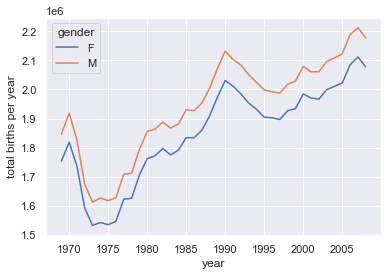

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and ``plot()`` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

### Further data exploration

Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

In [15]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution (You can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: ["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html) (Princeton University Press, 2014)).

With this we can use the ``query()`` method (discussed further in [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)) to filter-out rows with births outside these values:

In [16]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

In [17]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

Finally, we can combine the day, month, and year to create a Date index (see [Working with Time Series](03.11-Working-with-Time-Series.ipynb)).
This allows us to quickly compute the weekday corresponding to each row:

In [18]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

Using this we can plot births by weekday for several decades:

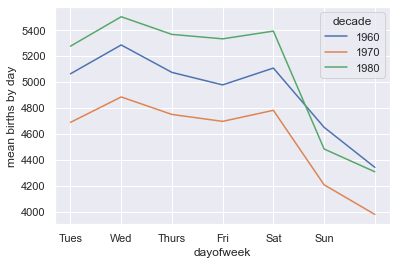

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

In [20]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

The result is a multi-index over months and days.
To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [21]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

<ipython-input-21-2b877f2df70b>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2012, month, day)


births
2012-01-01  4009.225
2012-01-02  4247.400
2012-01-03  4500.900
2012-01-04  4571.350
2012-01-05  4603.625

Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year.
From this, we can use the ``plot`` method to plot the data. It reveals some interesting trends:

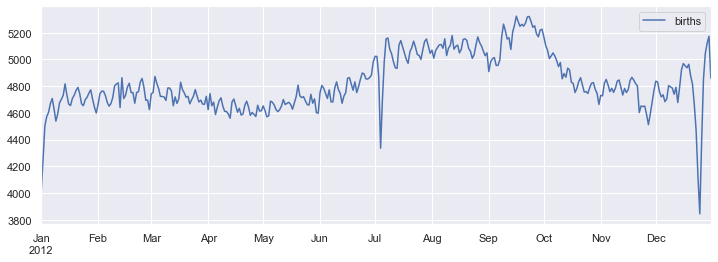

In [22]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

# Combining Datasets: Merge and Join

One essential feature offered by Pandas is its high-performance, in-memory join and merge operations.
If you have ever worked with databases, you should be familiar with this type of data interaction.
The main interface for this is the ``pd.merge`` function, and we'll see few examples of how this can work in practice.

For convenience, we will start by redefining the ``display()`` functionality from the previous section:

In [1]:
import pandas as pd
import numpy as np

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Relational Algebra

The behavior implemented in ``pd.merge()`` is a subset of what is known as *relational algebra*, which is a formal set of rules for manipulating relational data, and forms the conceptual foundation of operations available in most databases.
The strength of the relational algebra approach is that it proposes several primitive operations, which become the building blocks of more complicated operations on any dataset.
With this lexicon of fundamental operations implemented efficiently in a database or other program, a wide range of fairly complicated composite operations can be performed.

Pandas implements several of these fundamental building-blocks in the ``pd.merge()`` function and the related ``join()`` method of ``Series`` and ``Dataframe``s.
As we will see, these let you efficiently link data from different sources.

## Categories of Joins

The ``pd.merge()`` function implements a number of types of joins: the *one-to-one*, *many-to-one*, and *many-to-many* joins.
All three types of joins are accessed via an identical call to the ``pd.merge()`` interface; the type of join performed depends on the form of the input data.
Here we will show simple examples of the three types of merges, and discuss detailed options further below.

### One-to-one joins

Perhaps the simplest type of merge expresion is the one-to-one join, which is in many ways very similar to the column-wise concatenation seen in [Combining Datasets: Concat & Append](03.06-Concat-And-Append.ipynb).
As a concrete example, consider the following two ``DataFrames`` which contain information on several employees in a company:

In [2]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display('df1', 'df2')

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

To combine this information into a single ``DataFrame``, we can use the ``pd.merge()`` function:

In [3]:
df3 = pd.merge(df1, df2)
df3

employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

The ``pd.merge()`` function recognizes that each ``DataFrame`` has an "employee" column, and automatically joins using this column as a key.
The result of the merge is a new ``DataFrame`` that combines the information from the two inputs.
Notice that the order of entries in each column is not necessarily maintained: in this case, the order of the "employee" column differs between ``df1`` and ``df2``, and the ``pd.merge()`` function correctly accounts for this.
Additionally, keep in mind that the merge in general discards the index, except in the special case of merges by index (see the ``left_index`` and ``right_index`` keywords, discussed momentarily).

### Many-to-one joins

Many-to-one joins are joins in which one of the two key columns contains duplicate entries.
For the many-to-one case, the resulting ``DataFrame`` will preserve those duplicate entries as appropriate.
Consider the following example of a many-to-one join:

In [4]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
                    'supervisor': ['Carly', 'Guido', 'Steve']})
display('df3', 'df4', 'pd.merge(df3, df4)')

df3
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

df4
         group supervisor
0   Accounting      Carly
1  Engineering      Guido
2           HR      Steve

pd.merge(df3, df4)
  employee        group  hire_date supervisor
0      Bob   Accounting       2008      Carly
1     Jake  Engineering       2012      Guido
2     Lisa  Engineering       2004      Guido
3      Sue           HR       2014      Steve

The resulting ``DataFrame`` has an aditional column with the "supervisor" information, where the information is repeated in one or more locations as required by the inputs.

### Many-to-many joins

Many-to-many joins are a bit confusing conceptually, but are nevertheless well defined.
If the key column in both the left and right array contains duplicates, then the result is a many-to-many merge.
This will be perhaps most clear with a concrete example.
Consider the following, where we have a ``DataFrame`` showing one or more skills associated with a particular group.
By performing a many-to-many join, we can recover the skills associated with any individual person:

In [5]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Engineering', 'Engineering', 'HR', 'HR'],
                    'skills': ['math', 'spreadsheets', 'coding', 'linux',
                               'spreadsheets', 'organization']})
display('df1', 'df5', "pd.merge(df1, df5)")

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df5
         group        skills
0   Accounting          math
1   Accounting  spreadsheets
2  Engineering        coding
3  Engineering         linux
4           HR  spreadsheets
5           HR  organization

pd.merge(df1, df5)
  employee        group        skills
0      Bob   Accounting          math
1      Bob   Accounting  spreadsheets
2     Jake  Engineering        coding
3     Jake  Engineering         linux
4     Lisa  Engineering        coding
5     Lisa  Engineering         linux
6      Sue           HR  spreadsheets
7      Sue           HR  organization

These three types of joins can be used with other Pandas tools to implement a wide array of functionality.
But in practice, datasets are rarely as clean as the one we're working with here.
In the following section we'll consider some of the options provided by ``pd.merge()`` that enable you to tune how the join operations work.

## Specification of the Merge Key

We've already seen the default behavior of ``pd.merge()``: it looks for one or more matching column names between the two inputs, and uses this as the key.
However, often the column names will not match so nicely, and ``pd.merge()`` provides a variety of options for handling this.

### The ``on`` keyword

Most simply, you can explicitly specify the name of the key column using the ``on`` keyword, which takes a column name or a list of column names:

In [6]:
display('df1', 'df2', "pd.merge(df1, df2, on='employee')")

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

pd.merge(df1, df2, on='employee')
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

This option works only if both the left and right ``DataFrame``s have the specified column name.

### The ``left_on`` and ``right_on`` keywords

At times you may wish to merge two datasets with different column names; for example, we may have a dataset in which the employee name is labeled as "name" rather than "employee".
In this case, we can use the ``left_on`` and ``right_on`` keywords to specify the two column names:

In [7]:
df3 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'salary': [70000, 80000, 120000, 90000]})
display('df1', 'df3', 'pd.merge(df1, df3, left_on="employee", right_on="name")')

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1, df3, left_on="employee", right_on="name")
  employee        group  name  salary
0      Bob   Accounting   Bob   70000
1     Jake  Engineering  Jake   80000
2     Lisa  Engineering  Lisa  120000
3      Sue           HR   Sue   90000

The result has a redundant column that we can drop if desired–for example, by using the ``drop()`` method of ``DataFrame``s:

In [8]:
pd.merge(df1, df3, left_on="employee", right_on="name").drop('name', axis=1)

employee        group  salary
0      Bob   Accounting   70000
1     Jake  Engineering   80000
2     Lisa  Engineering  120000
3      Sue           HR   90000

### The ``left_index`` and ``right_index`` keywords

Sometimes, rather than merging on a column, you would instead like to merge on an index.
For example, your data might look like this:

In [9]:
df1a = df1.set_index('employee')
df2a = df2.set_index('employee')
display('df1a', 'df2a')

df1a
                group
employee             
Bob        Accounting
Jake      Engineering
Lisa      Engineering
Sue                HR

df2a
          hire_date
employee           
Lisa           2004
Bob            2008
Jake           2012
Sue            2014

You can use the index as the key for merging by specifying the ``left_index`` and/or ``right_index`` flags in ``pd.merge()``:

In [10]:
display('df1a', 'df2a',
        "pd.merge(df1a, df2a, left_index=True, right_index=True)")

df1a
                group
employee             
Bob        Accounting
Jake      Engineering
Lisa      Engineering
Sue                HR

df2a
          hire_date
employee           
Lisa           2004
Bob            2008
Jake           2012
Sue            2014

pd.merge(df1a, df2a, left_index=True, right_index=True)
                group  hire_date
employee                        
Bob        Accounting       2008
Jake      Engineering       2012
Lisa      Engineering       2004
Sue                HR       2014

For convenience, ``DataFrame``s implement the ``join()`` method, which performs a merge that defaults to joining on indices:

In [11]:
display('df1a', 'df2a', 'df1a.join(df2a)')

df1a
                group
employee             
Bob        Accounting
Jake      Engineering
Lisa      Engineering
Sue                HR

df2a
          hire_date
employee           
Lisa           2004
Bob            2008
Jake           2012
Sue            2014

df1a.join(df2a)
                group  hire_date
employee                        
Bob        Accounting       2008
Jake      Engineering       2012
Lisa      Engineering       2004
Sue                HR       2014

If you'd like to mix indices and columns, you can combine ``left_index`` with ``right_on`` or ``left_on`` with ``right_index`` to get the desired behavior:

In [12]:
display('df1a', 'df3', "pd.merge(df1a, df3, left_index=True, right_on='name')")

df1a
                group
employee             
Bob        Accounting
Jake      Engineering
Lisa      Engineering
Sue                HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1a, df3, left_index=True, right_on='name')
         group  name  salary
0   Accounting   Bob   70000
1  Engineering  Jake   80000
2  Engineering  Lisa  120000
3           HR   Sue   90000

All of these options also work with multiple indices and/or multiple columns; the interface for this behavior is very intuitive.
For more information on this, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

## Specifying Set Arithmetic for Joins

In all the preceding examples we have glossed over one important consideration in performing a join: the type of set arithmetic used in the join.
This comes up when a value appears in one key column but not the other. Consider this example:

In [13]:
df6 = pd.DataFrame({'name': ['Peter', 'Paul', 'Mary'],
                    'food': ['fish', 'beans', 'bread']},
                   columns=['name', 'food'])
df7 = pd.DataFrame({'name': ['Mary', 'Joseph'],
                    'drink': ['wine', 'beer']},
                   columns=['name', 'drink'])
display('df6', 'df7', 'pd.merge(df6, df7)')

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7)
   name   food drink
0  Mary  bread  wine

Here we have merged two datasets that have only a single "name" entry in common: Mary.
By default, the result contains the *intersection* of the two sets of inputs; this is what is known as an *inner join*.
We can specify this explicitly using the ``how`` keyword, which defaults to ``"inner"``:

In [14]:
pd.merge(df6, df7, how='inner')

name   food drink
0  Mary  bread  wine

Other options for the ``how`` keyword are ``'outer'``, ``'left'``, and ``'right'``.
An *outer join* returns a join over the union of the input columns, and fills in all missing values with NAs:

In [15]:
display('df6', 'df7', "pd.merge(df6, df7, how='outer')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='outer')
     name   food drink
0   Peter   fish   NaN
1    Paul  beans   NaN
2    Mary  bread  wine
3  Joseph    NaN  beer

The *left join* and *right join* return joins over the left entries and right entries, respectively.
For example:

In [16]:
display('df6', 'df7', "pd.merge(df6, df7, how='left')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='left')
    name   food drink
0  Peter   fish   NaN
1   Paul  beans   NaN
2   Mary  bread  wine

The output rows now correspond to the entries in the left input. Using
``how='right'`` works in a similar manner.

All of these options can be applied straightforwardly to any of the preceding join types.

## Overlapping Column Names: The ``suffixes`` Keyword

Finally, you may end up in a case where your two input ``DataFrame``s have conflicting column names.
Consider this example:

In [17]:
df8 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [1, 2, 3, 4]})
df9 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [3, 1, 4, 2]})
display('df8', 'df9', 'pd.merge(df8, df9, on="name")')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name")
   name  rank_x  rank_y
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

Because the output would have two conflicting column names, the merge function automatically appends a suffix ``_x`` or ``_y`` to make the output columns unique.
If these defaults are inappropriate, it is possible to specify a custom suffix using the ``suffixes`` keyword:

In [18]:
display('df8', 'df9', 'pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])
   name  rank_L  rank_R
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

These suffixes work in any of the possible join patterns, and work also if there are multiple overlapping columns.

For more information on these patterns, see [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) where we dive a bit deeper into relational algebra.
Also see the [Pandas "Merge, Join and Concatenate" documentation](http://pandas.pydata.org/pandas-docs/stable/merging.html) for further discussion of these topics.

## Example: US States Data

Merge and join operations come up most often when combining data from different sources.
Here we will consider an example of some data about US states and their populations.
The data files can be found at http://github.com/jakevdp/data-USstates/:

In [19]:
# Following are shell commands to download the data
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-population.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-areas.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-abbrevs.csv

Let's take a look at the three datasets, using the Pandas ``read_csv()`` function:

In [20]:
pop = pd.read_csv('data/state-population.csv')
areas = pd.read_csv('data/state-areas.csv')
abbrevs = pd.read_csv('data/state-abbrevs.csv')

display('pop.head()', 'areas.head()', 'abbrevs.head()')

pop.head()
  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0

areas.head()
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707

abbrevs.head()
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

Given this information, say we want to compute a relatively straightforward result: rank US states and territories by their 2010 population density.
We clearly have the data here to find this result, but we'll have to combine the datasets to find the result.

We'll start with a many-to-one merge that will give us the full state name within the population ``DataFrame``.
We want to merge based on the ``state/region``  column of ``pop``, and the ``abbreviation`` column of ``abbrevs``.
We'll use ``how='outer'`` to make sure no data is thrown away due to mismatched labels.

In [21]:
merged = pd.merge(pop, abbrevs, how='outer',
                  left_on='state/region', right_on='abbreviation')
merged = merged.drop('abbreviation', 1) # drop duplicate info
merged.head()

state/region     ages  year  population    state
0           AL  under18  2012   1117489.0  Alabama
1           AL    total  2012   4817528.0  Alabama
2           AL  under18  2010   1130966.0  Alabama
3           AL    total  2010   4785570.0  Alabama
4           AL  under18  2011   1125763.0  Alabama

Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls:

In [22]:
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state            True
dtype: bool

Some of the ``population`` info is null; let's figure out which these are!

In [23]:
merged[merged['population'].isnull()].head()

state/region     ages  year  population state
2448           PR  under18  1990         NaN   NaN
2449           PR    total  1990         NaN   NaN
2450           PR    total  1991         NaN   NaN
2451           PR  under18  1991         NaN   NaN
2452           PR    total  1993         NaN   NaN

It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.

More importantly, we see also that some of the new ``state`` entries are also null, which means that there was no corresponding entry in the ``abbrevs`` key!
Let's figure out which regions lack this match:

In [24]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

In [25]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state           False
dtype: bool

No more nulls in the ``state`` column: we're all set!

Now we can merge the result with the area data using a similar procedure.
Examining our results, we will want to join on the ``state`` column in both:

In [26]:
final = pd.merge(merged, areas, on='state', how='left')
final.head()

state/region     ages  year  population    state  area (sq. mi)
0           AL  under18  2012   1117489.0  Alabama        52423.0
1           AL    total  2012   4817528.0  Alabama        52423.0
2           AL  under18  2010   1130966.0  Alabama        52423.0
3           AL    total  2010   4785570.0  Alabama        52423.0
4           AL  under18  2011   1125763.0  Alabama        52423.0

Again, let's check for nulls to see if there were any mismatches:

In [27]:
final.isnull().any()

state/region     False
ages             False
year             False
population        True
state            False
area (sq. mi)     True
dtype: bool

There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:

In [28]:
final['state'][final['area (sq. mi)'].isnull()].unique()

array(['United States'], dtype=object)

We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [29]:
final.dropna(inplace=True)
final.head()

state/region     ages  year  population    state  area (sq. mi)
0           AL  under18  2012   1117489.0  Alabama        52423.0
1           AL    total  2012   4817528.0  Alabama        52423.0
2           AL  under18  2010   1130966.0  Alabama        52423.0
3           AL    total  2010   4785570.0  Alabama        52423.0
4           AL  under18  2011   1125763.0  Alabama        52423.0

Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2000, and the total population.
We'll use the ``query()`` function to do this quickly (this requires the ``numexpr`` package to be installed; see [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)):

In [30]:
data2010 = final.query("year == 2010 & ages == 'total'")
data2010.head()

state/region   ages  year  population       state  area (sq. mi)
3             AL  total  2010   4785570.0     Alabama        52423.0
91            AK  total  2010    713868.0      Alaska       656425.0
101           AZ  total  2010   6408790.0     Arizona       114006.0
189           AR  total  2010   2922280.0    Arkansas        53182.0
197           CA  total  2010  37333601.0  California       163707.0

Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state, and then compute the result:

In [31]:
data2010.set_index('state', inplace=True)
density = data2010['population'] / data2010['area (sq. mi)']

In [32]:
density.sort_values(ascending=False, inplace=True)
density.head()

state
District of Columbia    8898.897059
Puerto Rico             1058.665149
New Jersey              1009.253268
Rhode Island             681.339159
Connecticut              645.600649
dtype: float64

The result is a ranking of US states plus Washington, DC, and Puerto Rico in order of their 2010 population density, in residents per square mile.
We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.

We can also check the end of the list:

In [33]:
density.tail()

state
South Dakota    10.583512
North Dakota     9.537565
Montana          6.736171
Wyoming          5.768079
Alaska           1.087509
dtype: float64

# Hierarchical Indexing

Up to this point we've been focused primarily on one-dimensional and two-dimensional data, stored in Pandas ``Series`` and ``DataFrame`` objects, respectively.
Often it is useful to go beyond this and store higher-dimensional data–that is, data indexed by more than one or two keys.
While Pandas does provide ``Panel`` and ``Panel4D`` objects that natively handle three-dimensional and four-dimensional data (see [Aside: Panel Data](#Aside:-Panel-Data)), a far more common pattern in practice is to make use of *hierarchical indexing* (also known as *multi-indexing*) to incorporate multiple index *levels* within a single index.
In this way, higher-dimensional data can be compactly represented within the familiar one-dimensional ``Series`` and two-dimensional ``DataFrame`` objects.

In this section, we'll explore the direct creation of ``MultiIndex`` objects, considerations when indexing, slicing, and computing statistics across multiply indexed data, and useful routines for converting between simple and hierarchically indexed representations of your data.

We begin with the standard imports:

In [1]:
import pandas as pd
import numpy as np

## A Multiply Indexed Series

Let's start by considering how we might represent two-dimensional data within a one-dimensional ``Series``.
For concreteness, we will consider a series of data where each point has a character and numerical key.

### The bad way

Suppose you would like to track data about states from two different years.
Using the Pandas tools we've already covered, you might be tempted to simply use Python tuples as keys:

In [2]:
index = [('California', 2000), ('California', 2010),
         ('New York', 2000), ('New York', 2010),
         ('Texas', 2000), ('Texas', 2010)]
populations = [33871648, 37253956,
               18976457, 19378102,
               20851820, 25145561]
pop = pd.Series(populations, index=index)
pop

(California, 2000)    33871648
(California, 2010)    37253956
(New York, 2000)      18976457
(New York, 2010)      19378102
(Texas, 2000)         20851820
(Texas, 2010)         25145561
dtype: int64

With this indexing scheme, you can straightforwardly index or slice the series based on this multiple index:

In [3]:
pop[('California', 2010):('Texas', 2000)]

(California, 2010)    37253956
(New York, 2000)      18976457
(New York, 2010)      19378102
(Texas, 2000)         20851820
dtype: int64

But the convenience ends there. For example, if you need to select all values from 2010, you'll need to do some messy (and potentially slow) munging to make it happen:

In [4]:
pop[[i for i in pop.index if i[1] == 2010]]

(California, 2010)    37253956
(New York, 2010)      19378102
(Texas, 2010)         25145561
dtype: int64

This produces the desired result, but is not as clean (or as efficient for large datasets) as the slicing syntax we've grown to love in Pandas.

### The Better Way: Pandas MultiIndex
Fortunately, Pandas provides a better way.
Our tuple-based indexing is essentially a rudimentary multi-index, and the Pandas ``MultiIndex`` type gives us the type of operations we wish to have.
We can create a multi-index from the tuples as follows:

In [5]:
index = pd.MultiIndex.from_tuples(index)
index

MultiIndex([('California', 2000),
            ('California', 2010),
            (  'New York', 2000),
            (  'New York', 2010),
            (     'Texas', 2000),
            (     'Texas', 2010)],
           )

Notice that the ``MultiIndex`` contains multiple *levels* of indexing–in this case, the state names and the years, as well as multiple *labels* for each data point which encode these levels.

If we re-index our series with this ``MultiIndex``, we see the hierarchical representation of the data:

In [6]:
pop = pop.reindex(index)
pop

California  2000    33871648
            2010    37253956
New York    2000    18976457
            2010    19378102
Texas       2000    20851820
            2010    25145561
dtype: int64

Here the first two columns of the ``Series`` representation show the multiple index values, while the third column shows the data.
Notice that some entries are missing in the first column: in this multi-index representation, any blank entry indicates the same value as the line above it.

Now to access all data for which the second index is 2010, we can simply use the Pandas slicing notation:

In [7]:
pop[:, 2010]

California    37253956
New York      19378102
Texas         25145561
dtype: int64

The result is a singly indexed array with just the keys we're interested in.
This syntax is much more convenient (and the operation is much more efficient!) than the home-spun tuple-based multi-indexing solution that we started with.
We'll now further discuss this sort of indexing operation on hieararchically indexed data.

### MultiIndex as extra dimension

You might notice something else here: we could easily have stored the same data using a simple ``DataFrame`` with index and column labels.
In fact, Pandas is built with this equivalence in mind. The ``unstack()`` method will quickly convert a multiply indexed ``Series`` into a conventionally indexed ``DataFrame``:

In [8]:
pop_df = pop.unstack()
pop_df

2000      2010
California  33871648  37253956
New York    18976457  19378102
Texas       20851820  25145561

Naturally, the ``stack()`` method provides the opposite operation:

In [9]:
pop_df.stack()

California  2000    33871648
            2010    37253956
New York    2000    18976457
            2010    19378102
Texas       2000    20851820
            2010    25145561
dtype: int64

Seeing this, you might wonder why would we would bother with hierarchical indexing at all.
The reason is simple: just as we were able to use multi-indexing to represent two-dimensional data within a one-dimensional ``Series``, we can also use it to represent data of three or more dimensions in a ``Series`` or ``DataFrame``.
Each extra level in a multi-index represents an extra dimension of data; taking advantage of this property gives us much more flexibility in the types of data we can represent. Concretely, we might want to add another column of demographic data for each state at each year (say, population under 18) ; with a ``MultiIndex`` this is as easy as adding another column to the ``DataFrame``:

In [10]:
pop_df = pd.DataFrame({'total': pop,
                       'under18': [9267089, 9284094,
                                   4687374, 4318033,
                                   5906301, 6879014]})
pop_df

total  under18
California 2000  33871648  9267089
           2010  37253956  9284094
New York   2000  18976457  4687374
           2010  19378102  4318033
Texas      2000  20851820  5906301
           2010  25145561  6879014

In addition, all the ufuncs and other functionality discussed in [Operating on Data in Pandas](03.03-Operations-in-Pandas.ipynb) work with hierarchical indices as well.
Here we compute the fraction of people under 18 by year, given the above data:

In [11]:
f_u18 = pop_df['under18'] / pop_df['total']
f_u18.unstack()

2000      2010
California  0.273594  0.249211
New York    0.247010  0.222831
Texas       0.283251  0.273568

This allows us to easily and quickly manipulate and explore even high-dimensional data.

## Methods of MultiIndex Creation

The most straightforward way to construct a multiply indexed ``Series`` or ``DataFrame`` is to simply pass a list of two or more index arrays to the constructor. For example:

In [12]:
df = pd.DataFrame(np.random.rand(4, 2),
                  index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                  columns=['data1', 'data2'])
df

data1     data2
a 1  0.422944  0.260546
  2  0.464052  0.734658
b 1  0.431002  0.569218
  2  0.203545  0.807376

The work of creating the ``MultiIndex`` is done in the background.

Similarly, if you pass a dictionary with appropriate tuples as keys, Pandas will automatically recognize this and use a ``MultiIndex`` by default:

In [13]:
data = {('California', 2000): 33871648,
        ('California', 2010): 37253956,
        ('Texas', 2000): 20851820,
        ('Texas', 2010): 25145561,
        ('New York', 2000): 18976457,
        ('New York', 2010): 19378102}
pd.Series(data)

California  2000    33871648
            2010    37253956
Texas       2000    20851820
            2010    25145561
New York    2000    18976457
            2010    19378102
dtype: int64